## Importing Libraries ####

In [78]:
import pandas as pd
import numpy as np
import random
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [79]:
dataset = pd.read_csv('new_churn_data.csv')

 Data Preparation

In [80]:
user_identifier = dataset['user']
dataset = dataset.drop(columns = ['user'])

One-Hot Encoding

In [81]:
print(dataset.housing.value_counts())
##dataset.groupby('housing')['churn'].nunique().reset_index()
dataset = pd.get_dummies(dataset)
print(dataset.columns)

na    13856
R     10969
O      2171
Name: housing, dtype: int64
Index(['churn', 'age', 'deposits', 'withdrawal', 'purchases_partners',
       'purchases', 'cc_taken', 'cc_recommended', 'cc_disliked', 'cc_liked',
       'cc_application_begin', 'app_downloaded', 'web_user', 'ios_user',
       'android_user', 'registered_phones', 'waiting_4_loan', 'cancelled_loan',
       'received_loan', 'rejected_loan', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
       'housing_R', 'housing_na', 'payment_type_Bi-Weekly',
       'payment_type_Monthly', 'payment_type_Semi-Monthly',
       'payment_type_Weekly', 'payment_type_na', 'zodiac_sign_Aquarius',
       'zodiac_sign_Aries', 'zodiac_sign_Cancer', 'zodiac_sign_Capricorn',
       'zodiac_sign_Gemini', 'zodiac_sign_Leo', 'zodiac_sign_Libra',
       'zodiac_sign_Pisces', 'zodiac_sign_Sagittarius', 'zodiac_sign_Scorpio',
       'zodiac_sign_Taurus', 'zodiac_sign_Virgo', 'zodiac_sign_na'],
      dtyp

In [82]:
dataset = dataset.drop(columns = ['housing_na', 'zodiac_sign_na', 'payment_type_na'])

Splitting the dataset into the Training set and Test set

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = 'churn'), dataset['churn'],
                                                    test_size = 0.2,
                                                    random_state = 0)

Balancing the Training Set by deleteing instances 

In [84]:
y_train.value_counts()

0    12656
1     8940
Name: churn, dtype: int64

In [85]:
pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index

In [86]:
if len(pos_index) > len(neg_index):
    higher = pos_index
    lower = neg_index
else:
    higher = neg_index
    lower = pos_index

In [87]:
random.seed(0)
higher = np.random.choice(higher, size=len(lower))
lower = np.asarray(lower)
new_indexes = np.concatenate((lower, higher))

In [88]:
X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]

Feature Scaling

In [89]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [90]:
print('train dataset\n -----------')
print(X_train.head())

train dataset
 -----------
            age  deposits  withdrawal  purchases_partners  purchases  \
11695 -0.622309 -0.359927   -0.285826           -0.605397  -0.359503   
19766 -0.419580 -0.359927   -0.285826           -0.654554  -0.359503   
8354   0.289972 -0.359927   -0.285826           -0.654554  -0.359503   
17883  0.594066 -0.359927   -0.285826            0.033641  -0.359503   
25149 -0.825038 -0.247235   -0.285826           -0.113829  -0.244589   

       cc_taken  cc_recommended  cc_disliked  cc_liked  cc_application_begin  \
11695 -0.167006       -0.915113    -0.051788  -0.07293             -0.586806   
19766 -0.167006        0.320031     0.939621  -0.07293             -0.586806   
8354  -0.167006        2.012637    -0.051788  -0.07293             -0.244732   
17883 -0.167006       -0.183176    -0.051788  -0.07293              0.011823   
25149 -0.167006       -0.583454    -0.051788  -0.07293             -0.244732   

             ...          zodiac_sign_Cancer  zodiac_sign_C

## Model Building ####

Fitting Model to the Training Set

In [91]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Predicting Test Set

In [92]:
y_pred = classifier.predict(X_test)

Evaluating Results

In [93]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print('accuracy: ',accuracy_score(y_test, y_pred))
print('precision: ',precision_score(y_test, y_pred) )# tp / (tp + fp)
print('recall: ',recall_score(y_test, y_pred)) # tp / (tp + fn)
print('f1: ',f1_score(y_test, y_pred))

accuracy:  0.6159259259259259
precision:  0.5247371675943104
recall:  0.7596239928379588
f1:  0.6207022677395757


Test Data Accuracy: 0.6159


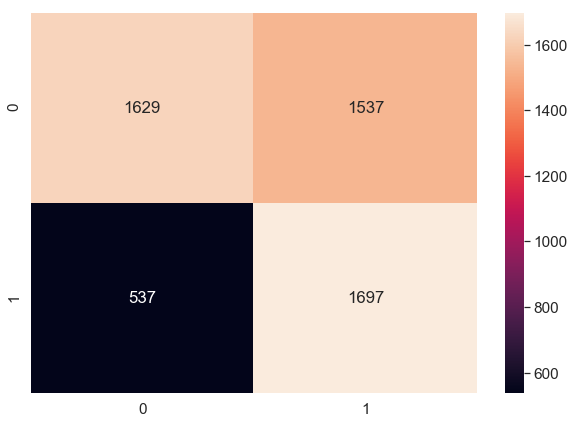

In [94]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

Applying k-Fold Cross Validation

In [95]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("LOG Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

LOG Accuracy: 0.652 (+/- 0.015)


Analyzing Coefficients

In [96]:
pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,age,-0.160262
1,deposits,0.228166
2,withdrawal,0.055262
3,purchases_partners,-0.766830
4,purchases,-0.372567
5,cc_taken,0.078389
6,cc_recommended,0.064948
7,cc_disliked,-0.023339
8,cc_liked,0.011002
9,cc_application_begin,0.049170


## Feature Selection ####

 Feature Selection<br>
Recursive Feature Elimination

In [97]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

Model to Test

In [98]:
classifier = LogisticRegression()
# Select Best X Features
rfe = RFE(classifier, 20)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
print(X_train.columns[rfe.support_])

[ True  True  True  True  True  True  True False False  True False  True
  True False  True  True  True  True  True  True  True  True False  True
 False  True False False False False False False False False False False
 False False False False False]
[ 1  1  1  1  1  1  1 12 19  1  4  1  1  3  1  1  1  1  1  1  1  1 11  1
  6  1  5  2 13  8 15 20 21  9 22  7 18 16 10 14 17]
Index(['age', 'deposits', 'withdrawal', 'purchases_partners', 'purchases',
       'cc_taken', 'cc_recommended', 'cc_application_begin', 'web_user',
       'ios_user', 'registered_phones', 'waiting_4_loan', 'cancelled_loan',
       'received_loan', 'rejected_loan', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'housing_O',
       'payment_type_Bi-Weekly'],
      dtype='object')


New Correlation Matrix

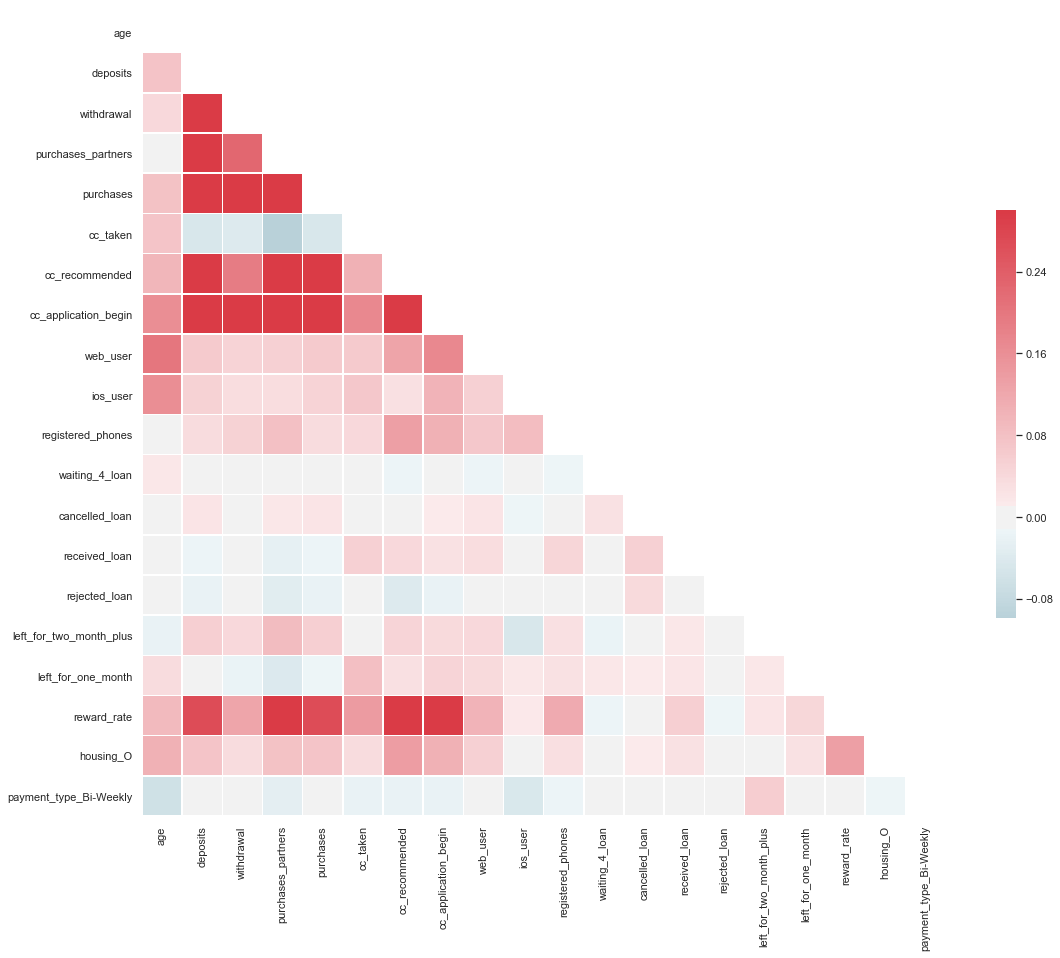

In [99]:
sn.set(style="white")

###Compute the correlation matrix
corr = X_train[X_train.columns[rfe.support_]].corr()

###Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

###Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

###Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)


###Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})    


Fitting Model to the Training Set

In [100]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Predicting Test Set

In [101]:
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

Evaluating Results

In [102]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print('accuracy: ',accuracy_score(y_test, y_pred))
print('precision: ',precision_score(y_test, y_pred) )# tp / (tp + fp)
print('recall: ',recall_score(y_test, y_pred)) # tp / (tp + fn)
print('f1: ',f1_score(y_test, y_pred))

accuracy:  0.6125925925925926
precision:  0.5218865598027127
recall:  0.7578334825425246
f1:  0.6181087988316905


Test Data Accuracy: 0.6126


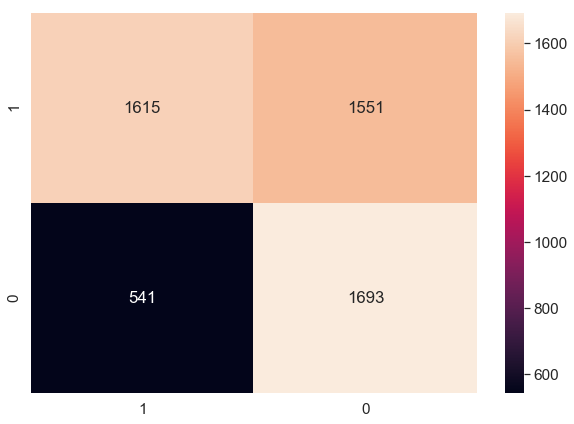

In [103]:
df_cm = pd.DataFrame(cm, index = (1, 0), columns = (1, 0))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

Applying k-Fold Cross Validation

In [104]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier,
                             X = X_train[X_train.columns[rfe.support_]],
                             y = y_train, cv = 10)
print("LOG Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

LOG Accuracy: 0.651 (+/- 0.011)


Analyzing Coefficients

In [105]:
pd.concat([pd.DataFrame(X_train[X_train.columns[rfe.support_]].columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,age,-0.167749
1,deposits,0.234072
2,withdrawal,0.057062
3,purchases_partners,-0.756133
4,purchases,-0.374936
5,cc_taken,0.077364
6,cc_recommended,0.077683
7,cc_application_begin,0.055463
8,web_user,0.124233
9,ios_user,0.094530


## End of Model ####

Formatting Final Results

In [106]:
final_results = pd.concat([y_test, user_identifier], axis = 1).dropna()
final_results['predicted_churn'] = y_pred
final_results = final_results[['user', 'churn', 'predicted_churn']].reset_index(drop=True)